In [2]:
import pandas as pd
import numpy as np 
import openpyxl
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re




In [3]:
def fonction_resultats(i):
    url = 'https://fbref.com/en/comps/13/' + str(i) +'-' + str(i+1) + '/schedule/' + str(i) +'-' + str(i+1) + '-Ligue-1-Scores-and-Fixtures'
    page = requests.get(url)
    html_content = page.content
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table')
    df = pd.read_html(str(table))[0].dropna(subset = 'Wk').dropna(subset = 'Score').reset_index(drop=True)
    df = df[['Wk', 'Home', 'Score', 'Away']]
    noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']
    df.insert(0,'Saison', str(i) + '-' + str(i+1))
    df['Buts domicile'] = df['Score'].str[0].astype(int)
    df['Buts extérieur'] = df['Score'].str[2].astype(int)
    df.drop(['Score'], axis = 1, inplace = True)
    df['Résultat'] = -1
    df.loc[df['Buts domicile'] > df['Buts extérieur'], 'Résultat'] = 1
    df.loc[df['Buts domicile'] == df['Buts extérieur'], 'Résultat'] = 0
    df.columns = noms_colonnes
    df['Journée'] = df['Journée'].astype(int)
    return df

noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']
dataframe_resultats = pd.DataFrame(columns=noms_colonnes)
for i in range (2002, 2023):
    try:
        resultats_finaux = fonction_resultats(i)
        dataframe_resultats = dataframe_resultats._append(resultats_finaux, ignore_index=True)
    except Exception as e:
        print(f"Erreur à l'élément {i}: {e}")

dataframe_resultats.to_csv('dataframe_résultats.csv', encoding = 'utf-8', index=False)


In [4]:
def fonction_classement(j):
    url = "https://www.deux-zero.com/ligue-1/classement-general/edition/" + str(j) + "-" + str(j+1) + "/init/1/fin/"
    df_classement = pd.DataFrame()
    annee = re.search(r'\d{4}-\d{4}', url).group()
    for i in range(1,39):
        url2 = url + str(i)
        page = requests.get(url2)
        soup = BeautifulSoup(page.text, "html.parser")

        tableau = soup.find("table", class_="tableau")
        equipes = tableau.select('tr.classement td.gras, tr.classement-avec-separateur td.gras')
        equipes_final = []
        for equipe in equipes:
            equipes_final.append(equipe.get_text(strip=True))
    
        classements = tableau.select('tr.classement span.flag-place, tr.classement-avec-separateur span.flag-place')
        classement_final = []
        for classement in classements:
            if classement.get_text(strip=True) == "-":
                classement_final.append(classement_final[-1])
            else:
                classement_final.append(classement.get_text(strip=True))
        dictionnaire_classement = dict(zip(equipes_final, classement_final))
        if i==1:
            df_classement["Équipes"] = equipes_final
            df_classement["J" + str(i)] = df_classement['Équipes'].map(dictionnaire_classement)
        else:
            df_classement["J" + str(i)] = df_classement['Équipes'].map(dictionnaire_classement)
    
    df_classement.insert(0,"Saison", str(annee))
    return(df_classement)


noms_colonnes = ["Saison", "Équipes"] + ["J{}".format(i) for i in range(1, 39)]
dataframe_classement = pd.DataFrame(columns=noms_colonnes)
for j in range(2002, 2023):
    classement = fonction_classement(j)
    dataframe_classement = dataframe_classement._append(classement, ignore_index=True)


dataframe_classement.to_csv('dataframe_classements.csv', encoding = 'utf-8', index=False)

In [7]:
dataframe_classement = pd.read_csv('dataframe_classements.csv', encoding = 'utf-8')
dataframe_final = pd.read_csv('dataframe_résultats.csv', encoding = 'utf-8')


glossaire = {'AS Monaco FC' : 'Monaco', 'FC Girondins de Bordeaux' : 'Bordeaux', 'FC Nantes Atlantique' : 'Nantes', 'GFC Ajaccio' : 'Gazélec Ajaccio',
'Havre AC' : 'Le Havre', 'Montpellier Hérault SC' : 'Montpellier', 'Paris Saint-Germain FC' : 'Paris S-G', 'Dijon FCO' : 'Dijon', 'Évian Thonon Gaillard FC' : 'Evian',
 'EA Guingamp' : 'Guingamp', 'Olympique Lyonnais' : 'Lyon', 'AC Ajaccio' : 'Ajaccio', 'SC Bastia' : 'Bastia', 'RC Lens' : 'Lens', 'RC Strasbourg' : 'Strasbourg',
 'RC Strasbourg Alsace' : 'Strasbourg', 'CS Sedan Ardennes' : 'Sedan', 'FC Sochaux-Montbéliard' : 'Sochaux', 'OGC Nice' : 'Nice', 'AC Arles Avignon' : 'Arles-Avignon',
 'AJ Auxerre' : 'Auxerre', 'Stade Rennais FC' : 'Rennes', 'Olympique de Marseille' : 'Marseille', 'Lille OSC' : 'Lille', 'Amiens SC' : 'Amiens', 'Nîmes Olympique' : 'Nîmes',
 'ESTAC Troyes' : 'Troyes', 'Toulouse FC' : 'Toulouse', 'Le Mans UC 72' : 'Le Mans', 'FC Metz' : 'Metz', 'SM Caen' : 'Caen', 'US Boulogne CO' : 'Boulogne',
 'FC Istres' : 'Istres', 'AS Saint-Etienne' : 'Saint-Étienne', 'AS Nancy Lorraine' : 'Nancy', 'FC Lorient' : 'Lorient', 'Stade Brestois 29' : 'Brest',
 'Valenciennes FC' : 'Valenciennes', 'Grenoble Foot 38' : 'Grenoble', 'FC Nantes' : 'Nantes', 'Clermont Foot 63' : 'Clermont Foot', 'Stade de Reims' : 'Reims','Angers SCO' : 'Angers'}

dataframe_classement['Équipes'] = dataframe_classement['Équipes'].replace(glossaire)


df_merge1 = pd.merge(dataframe_final, dataframe_classement, left_on=['Saison', 'Domicile'], right_on=['Saison', 'Équipes'], how='left')
conditions = [df_merge1['Journée'] == (i + 1) for i in range(1, max(df_merge1['Journée']) + 1)]
valeurs = [df_merge1[f'J{i}'] for i in range(1, max(df_merge1['Journée']) + 1)]
dataframe_final['Classement D'] = np.select(conditions, valeurs)
dataframe_final['Classement D'] = dataframe_final['Classement D'].replace({0: np.nan}).astype(pd.Int64Dtype())



df_merge2 = pd.merge(dataframe_final, dataframe_classement, left_on=['Saison', 'Extérieur'], right_on=['Saison', 'Équipes'], how='left')
conditions = [df_merge2['Journée'] == (i + 1) for i in range(1, max(df_merge2['Journée']) + 1)]
valeurs = [df_merge2[f'J{i}'] for i in range(1, max(df_merge2['Journée']) + 1)]
dataframe_final['Classement E'] = np.select(conditions, valeurs)
dataframe_final['Classement E'] = dataframe_final['Classement E'].replace({0: np.nan}).astype(pd.Int64Dtype())

dataframe_final.insert(4, 'Equipe 1 à Domicile', 1)
noms_colonnes = ['Saison', 'Journée', 'Equipe 1', 'Equipe 2', 'Equipe 1 à Domicile', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat', 'Classement Equipe 1', 'Classement Equipe 2']
dataframe_final.columns = noms_colonnes
dataframe_final_copie = dataframe_final.copy()[['Saison', 'Journée', 'Equipe 2', 'Equipe 1', 'Equipe 1 à Domicile', 'Buts Equipe 2', 'Buts Equipe 1', 'Résultat', 'Classement Equipe 2', 'Classement Equipe 1']]
dataframe_final_copie.columns = noms_colonnes
dataframe_final_copie['Equipe 1 à Domicile'] = 0
dataframe_final = dataframe_final._append(dataframe_final_copie, ignore_index=True)
dataframe_final = dataframe_final.sort_values(by=['Saison', 'Equipe 1', 'Journée']).reset_index(drop=True)
conditions = [
    (dataframe_final['Buts Equipe 1'] > dataframe_final['Buts Equipe 2']),
    (dataframe_final['Buts Equipe 1'] < dataframe_final['Buts Equipe 2'])
]
valeurs = [1, -1]
dataframe_final['Résultat'] = 0
dataframe_final['Résultat'] = np.select(conditions, valeurs)
dataframe_final['Moyenne_BM par 1'] = (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final['Buts Equipe 1']) / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount())
dataframe_final['Moyenne_BM par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BM par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum() - dataframe_final['Buts Equipe 1']) / 
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BM par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final['Moyenne_BM par 2 à Domicile'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1 à Domicile_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BM par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum() - dataframe_final['Buts Equipe 1']) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BM par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final['Moyenne_BM par 2 à Extérieur'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1 à Extérieur_y']
dataframe_final['Moyenne_BE par 1'] = (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final['Buts Equipe 2']) / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount())
dataframe_final['Moyenne_BE par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BE par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum() - dataframe_final['Buts Equipe 2']) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BE par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final['Moyenne_BE par 2 à Domicile'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1 à Domicile_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BE par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum() - dataframe_final['Buts Equipe 2']) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BE par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount()))

dataframe_final['Moyenne_BE par 2 à Extérieur'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1 à Extérieur_y']
dataframe_final['Forme 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Résultat'].rolling(window=6, min_periods=2).sum().reset_index(drop=True)-dataframe_final['Résultat']
dataframe_final['Forme 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Forme 1_y']
dataframe_final['Historique'] = dataframe_final.groupby(['Equipe 1', 'Equipe 2'])['Résultat'].cumsum() - dataframe_final['Résultat']


dataframe_final.to_csv('dataframe_final.csv', encoding = 'utf-8', index=False)



In [8]:
dataframe_final.head(60)

,Saison,Journée,Equipe 1,Equipe 2,Equipe 1 à Domicile,Buts Equipe 1,Buts Equipe 2,Résultat,Classement Equipe 1,Classement Equipe 2,...,Moyenne_BM par 2 à Extérieur,Moyenne_BE par 1,Moyenne_BE par 2,Moyenne_BE par 1 à Domicile,Moyenne_BE par 2 à Domicile,Moyenne_BE par 1 à Extérieur,Moyenne_BE par 2 à Extérieur,Forme 1,Forme 2,Historique
0,2002-2003,1,Ajaccio,Strasbourg,0,1,1,0,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2002-2003,2,Ajaccio,Guingamp,1,0,2,-1,9,7,...,NaN,1.000000,3.000000,NaN,3.000000,1.000000,NaN,0.0,0.0,0
2,2002-2003,3,Ajaccio,Paris S-G,0,2,2,0,16,6,...,0.000000,1.500000,0.000000,2.000000,0.000000,1.000000,0.000000,-1.0,1.0,0
3,2002-2003,4,Ajaccio,Sedan,1,1,0,1,15,19,...,1.000000,1.666667,2.333333,2.000000,0.500000,1.500000,6.000000,-1.0,-2.0,0
4,2002-2003,5,Ajaccio,Troyes,0,0,1,-1,13,17,...,0.000000,1.250000,1.500000,1.000000,3.000000,1.500000,0.000000,0.0,-2.0,0
5,2002-2003,6,Ajaccio,Montpellier,1,0,0,0,15,17,...,0.500000,1.200000,1.000000,1.000000,0.333333,1.333333,2.000000,-1.0,-2.0,0
6,2002-2003,7,Ajaccio,Bastia,0,2,1,1,15,12,...,0.333333,1.000000,1.333333,0.666667,0.666667,1.333333,2.000000,-1.0,-1.0,0
7,2002-2003,8,Ajaccio,Sochaux,1,0,1,-1,12,10,...,0.750000,1.000000,1.142857,0.666667,1.333333,1.250000,1.000000,1.0,1.0,0
8,2002-2003,9,Ajaccio,Marseille,0,1,3,-1,13,4,...,1.750000,1.000000,1.000000,0.750000,1.000000,1.250000,1.000000,0.0,2.0,0
9,2002-2003,10,Ajaccio,Nantes,1,1,0,1,17,13,...,1.000000,1.222222,1.555556,0.750000,1.500000,1.600000,1.600000,-2.0,-3.0,0


In [7]:
dataframe_final.groupby('Equipe 1 à Domicile')['Résultat'].value_counts().unstack()

Résultat,-1,0,1
Equipe 1 à Domicile,,,
0,3548,2208,2123
1,2123,2208,3548


In [8]:
dataframe_final.groupby('Equipe 1')['Résultat'].value_counts().unstack()

Résultat,-1,0,1
Equipe 1,,,
Ajaccio,147,91,66
Amiens,48,31,25
Angers,133,79,82
Arles-Avignon,24,11,3
Auxerre,144,120,154
Bastia,133,80,91
Bordeaux,226,234,290
Boulogne,21,10,7
Brest,113,73,70


In [9]:
dataframe_final.groupby('Classement Equipe 1')['Résultat'].value_counts().unstack()

Résultat,-1,0,1
Classement Equipe 1,,,
1,144,184,446
2,209,204,366
3,209,201,351
4,221,233,322
5,249,226,291
6,235,218,313
7,263,218,287
8,268,223,269
9,278,240,269


In [10]:
dataframe_final.groupby('Forme 1')['Résultat'].value_counts().unstack()

Résultat,-1,0,1
Forme 1,,,
-5.0,84,40,23
-4.0,178,121,138
-3.0,488,302,338
-2.0,751,547,617
-1.0,1032,780,878
0.0,1028,787,1019
1.0,895,728,989
2.0,590,527,680
3.0,326,297,488


In [11]:
pd.DataFrame(dataframe_final.groupby('Equipe 1')['Moyenne_BM par 1'].mean())

,Moyenne_BM par 1
Equipe 1,
Ajaccio,0.816380
Amiens,0.933391
Angers,1.161137
Arles-Avignon,0.521233
Auxerre,1.117636
Bastia,1.049451
Bordeaux,1.268430
Boulogne,0.730039
Brest,1.108968


In [12]:
pd.DataFrame(dataframe_final.groupby('Forme 1')['Moyenne_BM par 1'].mean())

,Moyenne_BM par 1
Forme 1,
-5.0,0.794387
-4.0,0.848303
-3.0,0.932659
-2.0,0.993210
-1.0,1.035177
0.0,1.173350
1.0,1.333426
2.0,1.443309
3.0,1.592464


C:\Users\vtgra\AppData\Local\Temp\ipykernel_19472\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


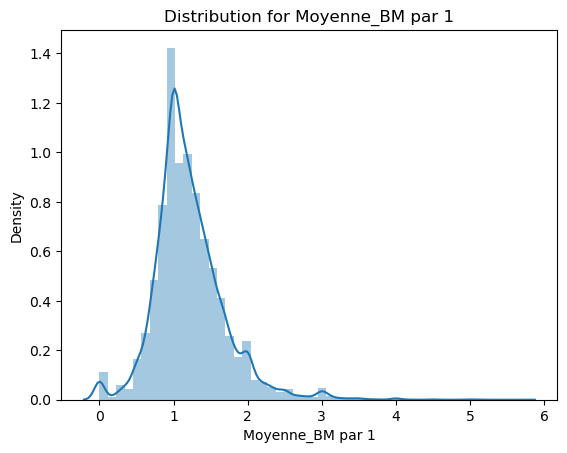

C:\Users\vtgra\AppData\Local\Temp\ipykernel_19472\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


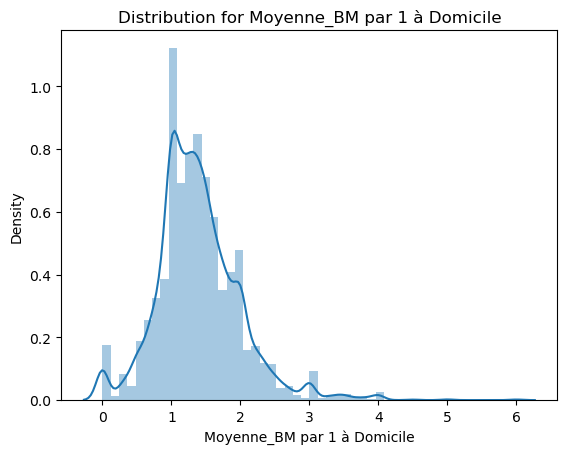

C:\Users\vtgra\AppData\Local\Temp\ipykernel_19472\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


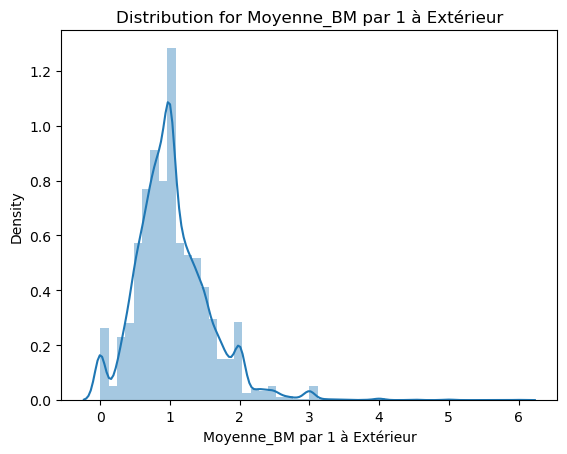

C:\Users\vtgra\AppData\Local\Temp\ipykernel_19472\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


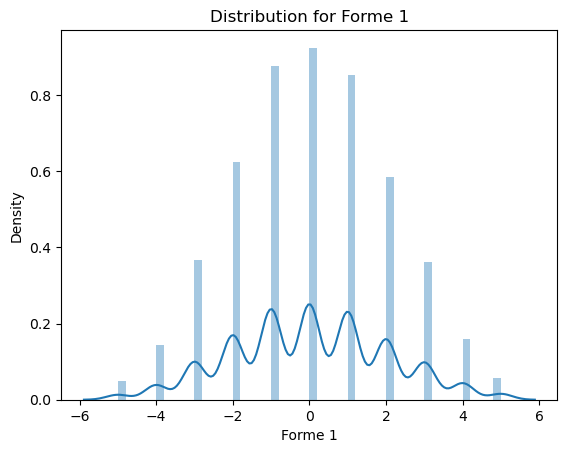

C:\Users\vtgra\AppData\Local\Temp\ipykernel_19472\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


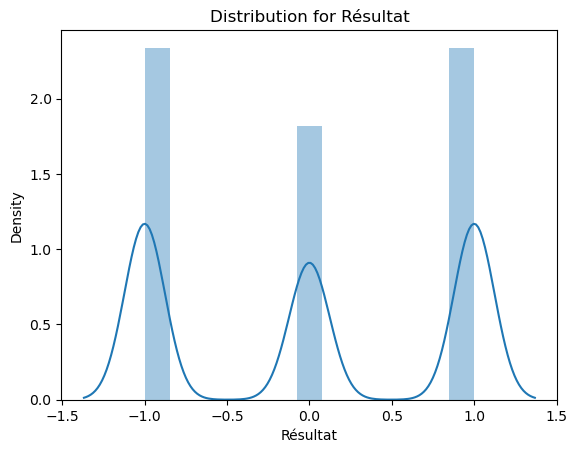

In [13]:
dataframe_plot = dataframe_final[['Moyenne_BM par 1','Moyenne_BM par 1 à Domicile', 'Moyenne_BM par 1 à Extérieur', 'Forme 1','Résultat']]
for col in dataframe_plot.select_dtypes('number').columns:
    sns.distplot(dataframe_plot[col])
    plt.title(f"Distribution for {col}")
    plt.show()

In [72]:
model=LinearRegression()
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
X_train = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)

#Régression sur le résultat
Y_train = dataframe_regression[["Résultat"]]
model.fit(X_train, Y_train)

Y_test =(model.predict(X_train))
dataframe_regression_copie = dataframe_regression.copy()
dataframe_regression_copie['pred'] = Y_test

conditions = [
    (dataframe_regression_copie['pred'] > 0.01),
    (dataframe_regression_copie['pred'] < -0.01)
]
valeurs = [1, -1]
dataframe_regression_copie['pred_résultat1'] = 0
dataframe_regression_copie['pred_résultat1'] = np.select(conditions, valeurs)

dataframe_regression_copie['Bon résultat1'] = dataframe_regression_copie['Résultat'] == dataframe_regression_copie['pred_résultat1']
print('Régression sur le Résultat')
print(dataframe_regression_copie['Bon résultat1'].value_counts())
print('accuracy: ' + str(dataframe_regression_copie['Bon résultat1'].value_counts()[True] / (dataframe_regression_copie['Bon résultat1'].value_counts()[True] + dataframe_regression_copie['Bon résultat1'].value_counts()[False])))

#Régression sur les Scores dont on déduit un Résultat
Y_train1 = dataframe_regression[["Buts Equipe 1"]]
model.fit(X_train, Y_train1)
Y_test1 =(model.predict(X_train))
dataframe_regression_copie['pred_buts 1'] = Y_test1 

Y_train2 = dataframe_regression[["Buts Equipe 2"]]
model.fit(X_train, Y_train2)
Y_test2 = (model.predict(X_train))
dataframe_regression_copie['pred_buts 2'] = Y_test2

conditions = [
    (dataframe_regression_copie['pred_buts 1'] > dataframe_regression_copie['pred_buts 2']),
    (dataframe_regression_copie['pred_buts 1'] < dataframe_regression_copie['pred_buts 2'])
]
valeurs = [1, -1]
dataframe_regression_copie['pred_résultat2'] = 0
dataframe_regression_copie['pred_résultat2'] = np.select(conditions, valeurs)
dataframe_regression_copie['Bon résultat2'] = dataframe_regression_copie['Résultat'] == dataframe_regression_copie['pred_résultat2']
print('Régression sur le Score et déduction du Résultat')
print(dataframe_regression_copie['Bon résultat2'].value_counts())
print('accuracy: ' + str(dataframe_regression_copie['Bon résultat2'].value_counts()[True] / (dataframe_regression_copie['Bon résultat2'].value_counts()[True] + dataframe_regression_copie['Bon résultat2'].value_counts()[False])))

#Random Forest sur le résultat
X_train = dataframe_regression[~(dataframe_regression['Saison'] == '2022-2023')].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
Y_train = dataframe_regression["Résultat"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Résultat']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
random_forest_model.fit(X_train, Y_train)
Y_pred= random_forest_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

print('Random Forest sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

df_22_23 = dataframe_regression_copie[dataframe_regression_copie['Saison']=='2022-2023'].drop(['pred','Bon résultat1', 'pred_buts 1', 'pred_buts 2', 'Bon résultat2'], axis=1)
df_22_23['pred_résultat3'] = Y_pred




Régression sur le Résultat
False    7658
True     7236
Name: Bon résultat1, dtype: int64
accuracy: 0.4858332214314489
Régression sur le Score et déduction du Résultat
False    7624
True     7270
Name: Bon résultat2, dtype: int64
accuracy: 0.4881160198737747
Random Forest sur le Résultat
Accuracy: 0.5306
Classification Report:
               precision    recall  f1-score   support

          -1       0.55      0.69      0.61       276
           0       0.23      0.05      0.08       168
           1       0.55      0.67      0.60       276

    accuracy                           0.53       720
   macro avg       0.44      0.47      0.43       720
weighted avg       0.47      0.53      0.48       720



In [73]:
#SVM model sur le résultat
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

df_22_23['pred_résultat4'] = Y_pred



Accuracy: 0.5194
Classification Report:
               precision    recall  f1-score   support

          -1       0.52      0.68      0.59       276
           0       0.00      0.00      0.00       168
           1       0.52      0.67      0.59       276

    accuracy                           0.52       720
   macro avg       0.35      0.45      0.39       720
weighted avg       0.40      0.52      0.45       720



In [74]:
poids_modele1 = 0.5
poids_modele2 = 0.5
poids_modele3 = 1.0
poids_modele4 = 1.0

poids_modeles = [poids_modele1, poids_modele2, poids_modele3, poids_modele4]

df_22_23['resultat_final_pondere'] = sum(poids * df_22_23[colonne] for poids, colonne in zip(poids_modeles, ['pred_résultat1', 'pred_résultat2', 'pred_résultat3', 'pred_résultat4']))

df_22_23['Résultat final'] = df_22_23['resultat_final_pondere'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))
df_22_23['Bon résultat'] = df_22_23['Résultat'] == df_22_23['Résultat final']
print(df_22_23['Bon résultat'].value_counts())
print('accuracy: ' + str(df_22_23['Bon résultat'].value_counts()[True] / (df_22_23['Bon résultat'].value_counts()[True] + df_22_23['Bon résultat'].value_counts()[False])))

 

True     395
False    325
Name: Bon résultat, dtype: int64
accuracy: 0.5486111111111112


In [10]:
#Random Forest sur le Score
X_train = dataframe_regression[~(dataframe_regression['Saison'] == '2022-2023')].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
Y_train1 = dataframe_regression["Buts Equipe 1"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test1 = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Buts Equipe 1']
Y_train2 = dataframe_regression["Buts Equipe 2"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test2 = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Buts Equipe 2']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)

random_forest_model.fit(X_train, Y_train1)
Y_pred1= random_forest_model.predict(X_test)

random_forest_model.fit(X_train, Y_train2)
Y_pred2= random_forest_model.predict(X_test)

accuracy1 = accuracy_score(Y_test1, Y_pred1)
classification_report_result1 = classification_report(Y_test1, Y_pred1)

accuracy2 = accuracy_score(Y_test2, Y_pred2)
classification_report_result2 = classification_report(Y_test2, Y_pred2)

print('Random Forest sur Buts Equipe 1')
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:\n", classification_report_result1)

print('Random Forest sur Buts Equipe 2')
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:\n", classification_report_result2)

df_22_23 = dataframe_regression_copie[dataframe_regression_copie['Saison']=='2022-2023']

df_22_23['pred_buts 1'] = Y_pred1.astype(int)
df_22_23['pred_buts 2'] = Y_pred2.astype(int)

conditions = [
    (df_22_23['pred_buts 1'] > df_22_23['pred_buts 2']),
    (df_22_23['pred_buts 1'] < df_22_23['pred_buts 2'])
]
valeurs = [1, -1]
df_22_23['Résultat prévu'] = 0
df_22_23['Résultat prévu'] = np.select(conditions, valeurs)
df_22_23['Bon_résultat'] = df_22_23['Résultat'] == df_22_23['Résultat prévu']
print('Random Forest sur le Score et déduction du Résultat')
print(df_22_23['Bon_résultat'].value_counts())

print('accuracy: ' + str(df_22_23['Bon_résultat'].value_counts()[True] / (df_22_23['Bon_résultat'].value_counts()[True] + df_22_23['Bon_résultat'].value_counts()[False])))


Random Forest sur Buts Equipe 1
Accuracy: 0.3333
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.37      0.35       178
           1       0.36      0.55      0.44       264
           2       0.26      0.18      0.21       158
           3       0.14      0.01      0.02        82
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3

    accuracy                           0.33       720
   macro avg       0.14      0.14      0.13       720
weighted avg       0.29      0.33      0.30       720

Random Forest sur Buts Equipe 2
Accuracy: 0.3250
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.35      0.33       178
           1       0.36      0.54      0.43       264
           2       0.24      0.18      0

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metr

In [68]:
model = LinearRegression()
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression[['BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D',
                      'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D', 'BE Equipe 2 à E si E']] = dataframe_regression.apply(
        lambda row: [row['Equipe 1 à Domicile'] * row['Moyenne_BM par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BM par 1 à Extérieur'], 
                     row['Equipe 1 à Domicile'] * row['Moyenne_BE par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur'],
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Extérieur'], 
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur']], axis=1, result_type='expand')
X_train = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)


#Régression sur le résultat
Y_train = dataframe_regression[["Résultat"]]
model.fit(X_train, Y_train)

Y_test =(model.predict(X_train))
dataframe_regression_copie = dataframe_regression.copy()
dataframe_regression_copie['pred'] = Y_test

conditions = [
    (dataframe_regression_copie['pred'] > 0.01),
    (dataframe_regression_copie['pred'] < -0.01)
]
valeurs = [1, -1]
dataframe_regression_copie['pred_résultat1'] = 0
dataframe_regression_copie['pred_résultat1'] = np.select(conditions, valeurs)

dataframe_regression_copie['Bon résultat1'] = dataframe_regression_copie['Résultat'] == dataframe_regression_copie['pred_résultat1']
print('Régression sur le Résultat')
print(dataframe_regression_copie['Bon résultat1'].value_counts())
print('accuracy: ' + str(dataframe_regression_copie['Bon résultat1'].value_counts()[True] / (dataframe_regression_copie['Bon résultat1'].value_counts()[True] + dataframe_regression_copie['Bon résultat1'].value_counts()[False])))

#Régression sur les Scores dont on déduit un Résultat
Y_train1 = dataframe_regression[["Buts Equipe 1"]]
model.fit(X_train, Y_train1)
Y_test1 =(model.predict(X_train))
dataframe_regression_copie['pred_buts 1'] = Y_test1 

Y_train2 = dataframe_regression[["Buts Equipe 2"]]
model.fit(X_train, Y_train2)
Y_test2 = (model.predict(X_train))
dataframe_regression_copie['pred_buts 2'] = Y_test2

conditions = [
    (dataframe_regression_copie['pred_buts 1'] > dataframe_regression_copie['pred_buts 2']),
    (dataframe_regression_copie['pred_buts 1'] < dataframe_regression_copie['pred_buts 2'])
]
valeurs = [1, -1]
dataframe_regression_copie['pred_résultat2'] = 0
dataframe_regression_copie['pred_résultat2'] = np.select(conditions, valeurs)
dataframe_regression_copie['Bon résultat2'] = dataframe_regression_copie['Résultat'] == dataframe_regression_copie['pred_résultat2']
print('Régression sur le Score et déduction du Résultat')
print(dataframe_regression_copie['Bon résultat2'].value_counts())
print('accuracy: ' + str(dataframe_regression_copie['Bon résultat2'].value_counts()[True] / (dataframe_regression_copie['Bon résultat2'].value_counts()[True] + dataframe_regression_copie['Bon résultat2'].value_counts()[False])))

#Random Forest sur le résultat
X_train = dataframe_regression[~(dataframe_regression['Saison'] == '2022-2023')].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
Y_train = dataframe_regression["Résultat"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Résultat']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
random_forest_model.fit(X_train, Y_train)
Y_pred= random_forest_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

print('Random Forest sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

df_22_23 = dataframe_regression_copie[dataframe_regression_copie['Saison']=='2022-2023'].drop(['pred','Bon résultat1', 'pred_buts 1', 'pred_buts 2', 'Bon résultat2'], axis=1)
df_22_23['pred_résultat3'] = Y_pred


Régression sur le Résultat
False    7641
True     7253
Name: Bon résultat1, dtype: int64
accuracy: 0.48697462065261177
Régression sur le Score et déduction du Résultat
False    7603
True     7291
Name: Bon résultat2, dtype: int64
accuracy: 0.4895259836175641
Random Forest sur le Résultat
Accuracy: 0.5319
Classification Report:
               precision    recall  f1-score   support

          -1       0.56      0.68      0.62       276
           0       0.21      0.05      0.09       168
           1       0.55      0.67      0.60       276

    accuracy                           0.53       720
   macro avg       0.44      0.47      0.43       720
weighted avg       0.47      0.53      0.49       720



In [69]:
#SVM model sur le résultat
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

df_22_23['pred_résultat4'] = Y_pred

Accuracy: 0.5333
Classification Report:
               precision    recall  f1-score   support

          -1       0.54      0.70      0.61       276
           0       0.17      0.01      0.01       168
           1       0.53      0.69      0.60       276

    accuracy                           0.53       720
   macro avg       0.41      0.46      0.41       720
weighted avg       0.45      0.53      0.47       720



In [70]:
poids_modele1 = 0.5
poids_modele2 = 0.5
poids_modele3 = 1
poids_modele4 = 1

poids_modeles = [poids_modele1, poids_modele2, poids_modele3, poids_modele4]

df_22_23['resultat_final_pondere'] = sum(poids * df_22_23[colonne] for poids, colonne in zip(poids_modeles, ['pred_résultat1', 'pred_résultat2', 'pred_résultat3', 'pred_résultat4']))

df_22_23['Résultat final'] = df_22_23['resultat_final_pondere'].apply(lambda x: 1 if x > 0.5 else (-1 if x < -0.5 else 0))
df_22_23['Bon résultat'] = df_22_23['Résultat'] == df_22_23['Résultat final']
print(df_22_23['Bon résultat'].value_counts())
print(df_22_23.groupby('Résultat final')['Bon résultat'].value_counts())
print('accuracy: ' + str(df_22_23['Bon résultat'].value_counts()[True] / (df_22_23['Bon résultat'].value_counts()[True] + df_22_23['Bon résultat'].value_counts()[False])))


True     397
False    323
Name: Bon résultat, dtype: int64
Résultat final  Bon résultat
-1              True            199
                False           161
 0              True              4
                False             3
 1              True            194
                False           159
Name: Bon résultat, dtype: int64
accuracy: 0.5513888888888889


In [13]:
#Random Forest sur le Score
X_train = dataframe_regression[~(dataframe_regression['Saison'] == '2022-2023')].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
Y_train1 = dataframe_regression["Buts Equipe 1"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test1 = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Buts Equipe 1']
Y_train2 = dataframe_regression["Buts Equipe 2"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test2 = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Buts Equipe 2']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)

random_forest_model.fit(X_train, Y_train1)
Y_pred1= random_forest_model.predict(X_test)

random_forest_model.fit(X_train, Y_train2)
Y_pred2= random_forest_model.predict(X_test)

accuracy1 = accuracy_score(Y_test1, Y_pred1)
classification_report_result1 = classification_report(Y_test1, Y_pred1)

accuracy2 = accuracy_score(Y_test2, Y_pred2)
classification_report_result2 = classification_report(Y_test2, Y_pred2)

print('Random Forest sur Buts Equipe 1')
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:\n", classification_report_result1)

print('Random Forest sur Buts Equipe 2')
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:\n", classification_report_result2)

df_22_23 = dataframe_regression_copie[dataframe_regression_copie['Saison']=='2022-2023']

df_22_23['pred_buts 1'] = Y_pred1.astype(int)
df_22_23['pred_buts 2'] = Y_pred2.astype(int)

conditions = [
    (df_22_23['pred_buts 1'] > df_22_23['pred_buts 2']),
    (df_22_23['pred_buts 1'] < df_22_23['pred_buts 2'])
]
valeurs = [1, -1]
df_22_23['Résultat prévu'] = 0
df_22_23['Résultat prévu'] = np.select(conditions, valeurs)
df_22_23['Bon_résultat'] = df_22_23['Résultat'] == df_22_23['Résultat prévu']
print('Random Forest sur le Score et déduction du Résultat')
print(df_22_23['Bon_résultat'].value_counts())

print('accuracy: ' + str(df_22_23['Bon_résultat'].value_counts()[True] / (df_22_23['Bon_résultat'].value_counts()[True] + df_22_23['Bon_résultat'].value_counts()[False])))


Random Forest sur Buts Equipe 1
Accuracy: 0.3111
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.35      0.34       178
           1       0.35      0.52      0.42       264
           2       0.20      0.15      0.17       158
           3       0.00      0.00      0.00        82
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3

    accuracy                           0.31       720
   macro avg       0.11      0.13      0.12       720
weighted avg       0.25      0.31      0.27       720

Random Forest sur Buts Equipe 2
Accuracy: 0.3208
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.34      0.33       178
           1       0.36      0.52      0.42       264
           2       0.24      0.19      0

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metr

In [62]:
model=LinearRegression()
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression[['BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D',
                      'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D', 'BE Equipe 2 à E si E']] = dataframe_regression.apply(
        lambda row: [row['Equipe 1 à Domicile'] * row['Moyenne_BM par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BM par 1 à Extérieur'], 
                     row['Equipe 1 à Domicile'] * row['Moyenne_BE par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur'],
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Extérieur'], 
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur']], axis=1, result_type='expand')
X_train = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat','Moyenne_BM par 1 à Domicile',
                                     'Moyenne_BM par 1 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur','Moyenne_BM par 2 à Domicile',
                                     'Moyenne_BM par 2 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur'], axis = 1)


#Régression sur le résultat
Y_train = dataframe_regression[["Résultat"]]
model.fit(X_train, Y_train)

Y_test =(model.predict(X_train))
dataframe_regression_copie = dataframe_regression.copy()
dataframe_regression_copie['pred'] = Y_test

conditions = [
    (dataframe_regression_copie['pred'] > 0.01),
    (dataframe_regression_copie['pred'] < -0.01)
]
valeurs = [1, -1]
dataframe_regression_copie['pred_résultat1'] = 0
dataframe_regression_copie['pred_résultat1'] = np.select(conditions, valeurs)

dataframe_regression_copie['Bon résultat1'] = dataframe_regression_copie['Résultat'] == dataframe_regression_copie['pred_résultat1']
print('Régression sur le Résultat')
print(dataframe_regression_copie['Bon résultat1'].value_counts())
print('accuracy: ' + str(dataframe_regression_copie['Bon résultat1'].value_counts()[True] / (dataframe_regression_copie['Bon résultat1'].value_counts()[True] + dataframe_regression_copie['Bon résultat1'].value_counts()[False])))

#Régression sur les Scores dont on déduit un Résultat
Y_train1 = dataframe_regression[["Buts Equipe 1"]]
model.fit(X_train, Y_train1)
Y_test1 =(model.predict(X_train))
dataframe_regression_copie['pred_buts 1'] = Y_test1 

Y_train2 = dataframe_regression[["Buts Equipe 2"]]
model.fit(X_train, Y_train2)
Y_test2 = (model.predict(X_train))
dataframe_regression_copie['pred_buts 2'] = Y_test2

conditions = [
    (dataframe_regression_copie['pred_buts 1'] > dataframe_regression_copie['pred_buts 2']),
    (dataframe_regression_copie['pred_buts 1'] < dataframe_regression_copie['pred_buts 2'])
]
valeurs = [1, -1]
dataframe_regression_copie['pred_résultat2'] = 0
dataframe_regression_copie['pred_résultat2'] = np.select(conditions, valeurs)
dataframe_regression_copie['Bon résultat2'] = dataframe_regression_copie['Résultat'] == dataframe_regression_copie['pred_résultat2']
print('Régression sur le Score et déduction du Résultat')
print(dataframe_regression_copie['Bon résultat2'].value_counts())
print('accuracy: ' + str(dataframe_regression_copie['Bon résultat2'].value_counts()[True] / (dataframe_regression_copie['Bon résultat2'].value_counts()[True] + dataframe_regression_copie['Bon résultat2'].value_counts()[False])))

#Random Forest sur le résultat
X_train = dataframe_regression[~(dataframe_regression['Saison'] == '2022-2023')].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
Y_train = dataframe_regression["Résultat"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Résultat']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
random_forest_model.fit(X_train, Y_train)
Y_pred= random_forest_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

print('Random Forest sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

df_22_23 = dataframe_regression_copie[dataframe_regression_copie['Saison']=='2022-2023'].drop(['pred','Bon résultat1', 'pred_buts 1', 'pred_buts 2', 'Bon résultat2'], axis=1)
df_22_23['pred_résultat3'] = Y_pred

Régression sur le Résultat
False    7703
True     7191
Name: Bon résultat1, dtype: int64
accuracy: 0.4828118705519001
Régression sur le Score et déduction du Résultat
False    7640
True     7254
Name: Bon résultat2, dtype: int64
accuracy: 0.4870417617832684
Random Forest sur le Résultat
Accuracy: 0.5319
Classification Report:
               precision    recall  f1-score   support

          -1       0.56      0.68      0.62       276
           0       0.21      0.05      0.09       168
           1       0.55      0.67      0.60       276

    accuracy                           0.53       720
   macro avg       0.44      0.47      0.43       720
weighted avg       0.47      0.53      0.49       720



In [64]:
#SVM model sur le résultat
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

df_22_23['pred_résultat4'] = Y_pred

Accuracy: 0.5333
Classification Report:
               precision    recall  f1-score   support

          -1       0.54      0.70      0.61       276
           0       0.17      0.01      0.01       168
           1       0.53      0.69      0.60       276

    accuracy                           0.53       720
   macro avg       0.41      0.46      0.41       720
weighted avg       0.45      0.53      0.47       720



In [67]:
poids_modele1 = 0.5
poids_modele2 = 0.5
poids_modele3 = 1
poids_modele4 = 1

poids_modeles = [poids_modele1, poids_modele2, poids_modele3, poids_modele4]

df_22_23['resultat_final_pondere'] = sum(poids * df_22_23[colonne] for poids, colonne in zip(poids_modeles, ['pred_résultat1', 'pred_résultat2', 'pred_résultat3', 'pred_résultat4']))

df_22_23['Résultat final'] = df_22_23['resultat_final_pondere'].apply(lambda x: 1 if x > 0.5 else (-1 if x < -0.5 else 0))
df_22_23['Bon résultat'] = df_22_23['Résultat'] == df_22_23['Résultat final']
print(df_22_23['Bon résultat'].value_counts())
print(df_22_23.groupby('Résultat final')['Bon résultat'].value_counts())
print('accuracy: ' + str(df_22_23['Bon résultat'].value_counts()[True] / (df_22_23['Bon résultat'].value_counts()[True] + df_22_23['Bon résultat'].value_counts()[False])))


True     398
False    322
Name: Bon résultat, dtype: int64
Résultat final  Bon résultat
-1              True            199
                False           159
 0              False             5
                True              5
 1              True            194
                False           158
Name: Bon résultat, dtype: int64
accuracy: 0.5527777777777778


In [71]:
model=LinearRegression()
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression[['BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D',
                      'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D', 'BE Equipe 2 à E si E']] = dataframe_regression.apply(
        lambda row: [row['Equipe 1 à Domicile'] * row['Moyenne_BM par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BM par 1 à Extérieur'], 
                     row['Equipe 1 à Domicile'] * row['Moyenne_BE par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur'],
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Extérieur'], 
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur']], axis=1, result_type='expand')
X_train = dataframe_regression[~(dataframe_regression['Saison'] == '2022-2023')].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 
                                    'Résultat','Moyenne_BM par 1 à Domicile', 'Moyenne_BM par 1 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur',
                                    'Moyenne_BM par 2 à Domicile', 'Moyenne_BM par 2 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur'], axis = 1)

Y_train1 = dataframe_regression["Buts Equipe 1"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test1 = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Buts Equipe 1']
Y_train2 = dataframe_regression["Buts Equipe 2"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test2 = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Buts Equipe 2']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'].drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 
                                    'Résultat','Moyenne_BM par 1 à Domicile', 'Moyenne_BM par 1 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur',
                                    'Moyenne_BM par 2 à Domicile', 'Moyenne_BM par 2 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur'], axis = 1)

random_forest_model.fit(X_train, Y_train1)
Y_pred1= random_forest_model.predict(X_test)

random_forest_model.fit(X_train, Y_train2)
Y_pred2= random_forest_model.predict(X_test)

accuracy1 = accuracy_score(Y_test1, Y_pred1)
classification_report_result1 = classification_report(Y_test1, Y_pred1)

accuracy2 = accuracy_score(Y_test2, Y_pred2)
classification_report_result2 = classification_report(Y_test2, Y_pred2)

print('Random Forest sur Buts Equipe 1')
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:\n", classification_report_result1)

print('Random Forest sur Buts Equipe 2')
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:\n", classification_report_result2)

df_22_23 = dataframe_regression_copie[dataframe_regression_copie['Saison']=='2022-2023']

df_22_23['pred_buts 1'] = Y_pred1.astype(int)
df_22_23['pred_buts 2'] = Y_pred2.astype(int)

conditions = [
    (df_22_23['pred_buts 1'] > df_22_23['pred_buts 2']),
    (df_22_23['pred_buts 1'] < df_22_23['pred_buts 2'])
]
valeurs = [1, -1]
df_22_23['Résultat prévu'] = 0
df_22_23['Résultat prévu'] = np.select(conditions, valeurs)
df_22_23['Bon_résultat'] = df_22_23['Résultat'] == df_22_23['Résultat prévu']
print('Random Forest sur le Score et déduction du Résultat')
print(df_22_23['Bon_résultat'].value_counts())

print('accuracy: ' + str(df_22_23['Bon_résultat'].value_counts()[True] / (df_22_23['Bon_résultat'].value_counts()[True] + df_22_23['Bon_résultat'].value_counts()[False])))

Random Forest sur Buts Equipe 1
Accuracy: 0.3069
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.34      0.33       178
           1       0.35      0.53      0.42       264
           2       0.17      0.13      0.15       158
           3       0.10      0.01      0.02        82
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3

    accuracy                           0.31       720
   macro avg       0.12      0.13      0.11       720
weighted avg       0.26      0.31      0.27       720

Random Forest sur Buts Equipe 2
Accuracy: 0.3014
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.31      0.31       178
           1       0.34      0.53      0.42       264
           2       0.18      0.12      0

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metr